In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import numpy as np
import pandas as pd
from google.cloud import bigquery
import os
sa_account_file = 'bq_key.json'
if os.path.isfile(sa_account_file) and not os.environ.get('GOOGLE_APPLICATION_CREDENTIALS'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = sa_account_file


pd.set_option("display.max_rows", 320)


/opt/conda/envs/z/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
r = bigquery.Client()
q = """
SELECT * FROM `ingka-search-modelling-dev.search_data.top_10k_queries` LIMIT 1000
"""
r.query(q).to_dataframe()

,searchKeyword,searchCount,ctr
0,wardrobe,613283,0.448881
1,desk,568564,0.445936
2,kallax,416831,0.556699
3,mirror,334740,0.410904
4,chest of drawers,250499,0.489558
...,...,...,...
995,high chair baby,4495,0.517446
996,kitchen chairs,4491,0.228295
997,oven dish,4487,0.366569
998,mammut,4486,0.492437


In [2]:
model_name = "/home/gikok/saved_model_7_epoch/"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
print("Model and tokenizer loaded")

model.parallelize()
print("Moved model to GPUs")
model_name1 = "/home/gikok/output_016/"

new = AutoModelForSeq2SeqLM.from_pretrained('bigscience/T0_3B')
tokenizer = AutoTokenizer.from_pretrained('bigscience/T0_3B')

# get all item_no and add as tokens
items = pd.read_parquet("../training/data/item_no_6k.parquet.gzip")["item_no"].values.tolist()
tokenizer.add_tokens(items)

# then resize embeddings
new.resize_token_embeddings(len(tokenizer))

# model1 = AutoModelForSeq2SeqLM.from_pretrained(model_name1)
# tokenizer1 = AutoTokenizer.from_pretrained(model_name1)
# print("Model and tokenizer loaded")

# model1.parallelize()
# print("Moved model to GPUs")
# model_name2 = "/home/gikok/output_002/"

# model2 = AutoModelForSeq2SeqLM.from_pretrained(model_name2)
# tokenizer2 = AutoTokenizer.from_pretrained(model_name2)
# print("Model and tokenizer loaded")

# model2.parallelize()
# print("Moved model to GPUs")

Model and tokenizer loaded
Moved model to GPUs


Embedding(38136, 2048)

In [4]:
embeddings = list(model.named_parameters())[0][1]
lm_head = list(model.named_parameters())[-1][1]
# embeddings1 = list(model1.named_parameters())[0][1]
# lm_head1 = list(model1.named_parameters())[-1][1]
initial_emb = list(new.named_parameters())[0][1]
initial_lm = list(new.named_parameters())[-1][1]

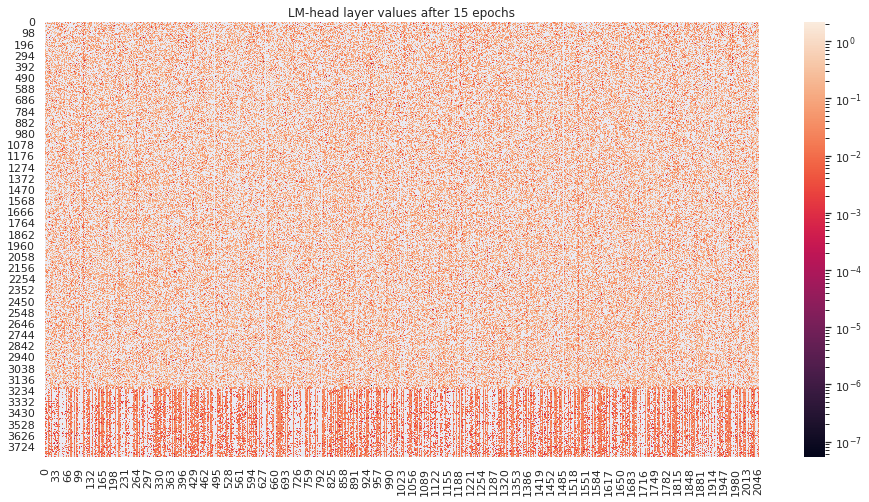

In [11]:
emb = lm_head[1::10,:]
emb1 = initial_lm[1::10,:]
import seaborn as sns
from matplotlib.colors import LogNorm
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import torch
import matplotlib.pyplot as plt
with torch.no_grad():
    fig, ax = plt.subplots(figsize=(16,8))
    #heat_map = abs(emb.add(-emb1))#torch.matmul(emb.cpu(), emb1.T.cpu())
    #heat_map[heat_map<1e-4]=1e-44
    ax = sns.heatmap(emb.cpu(), norm=LogNorm())
    plt.title('LM-head layer values after 15 epochs')

In [7]:
plt.close()

In [8]:
embeddings1, lm_head1

(Parameter containing:
 tensor([[ 1.4355e-01,  3.8750e+00,  5.3516e-01,  ...,  3.0875e+01,
           1.3281e+00, -2.1500e+01],
         [-4.7812e+00,  7.3125e+00,  3.3438e+00,  ...,  1.0312e+01,
          -8.7109e-01, -1.3047e+00],
         [-4.9023e-01,  2.3906e+00, -5.1562e+00,  ..., -5.4297e-01,
           9.8750e+00, -1.3562e+01],
         ...,
         [-2.3773e-01, -4.4270e-01,  1.2582e+00,  ...,  1.7632e+00,
           9.7722e-01, -6.2005e-01],
         [-6.9064e-01, -1.8996e-02,  6.5908e-02,  ...,  1.0842e+00,
          -9.9326e-01,  1.2279e+00],
         [ 4.7744e-01,  8.7684e-01,  7.3150e-01,  ..., -9.7299e-01,
          -3.3360e-01, -2.1407e-01]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.0476, -0.0623, -0.0977,  ...,  0.0262,  0.0427, -0.0295],
         [-0.0674, -0.0129, -0.1523,  ..., -0.1436, -0.0286,  0.0645],
         [-0.0310, -0.1582,  0.2676,  ...,  0.0461, -0.0747,  0.1699],
         ...,
         [-0.0189,  0.0276,  0.0140,  ...,  

In [9]:
inputs = tokenizer.encode("What is a cow?", return_tensors="pt")
inputs = inputs.to("cuda:0")
with torch.no_grad():
    print(tokenizer.decode(model.generate(inputs)[0], skip_special_tokens=True))

A cow is a dairy animal that is bred for milk.


In [10]:
inputs = tokenizer1.encode("99388356?", return_tensors="pt")
inputs = inputs.to("cuda:0")
with torch.no_grad():
    print(tokenizer1.decode(model1.generate(inputs)[0], skip_special_tokens=True))

Is it a sex toy?


In [11]:
with torch.no_grad():
    data1[0][1][:len(tokenizer),:]=torch.tensor(data[0][1][:len(tokenizer),:])
    data1[-1][1][:len(tokenizer),:]=torch.tensor(data[-1][1][:len(tokenizer),:])

NameError: name 'data' is not defined

In [ ]:
inputs

tensor([[32110,     1]], device='cuda:0')

In [ ]:
inputs = tokenizer1.encode("query: 'copper pans'\nfor the query above, what item_no is the best match? '10364523' or '50451052'?", return_tensors="pt")
inputs = inputs.to("cuda:0")
with torch.no_grad():
    print(tokenizer1.decode(model1.generate(inputs)[0], skip_special_tokens=True))

'best match'


In [ ]:
new = AutoModelForSeq2SeqLM.from_pretrained('bigscience/T0_3B')
tokenizer = AutoTokenizer.from_pretrained('bigscience/T0_3B')

# get all item_no and add as tokens
items = pd.read_parquet("../training/data/item_no_6k.parquet.gzip")["item_no"].values.tolist()
tokenizer.add_tokens(items)

# then resize embeddings
new.resize_token_embeddings(len(tokenizer))

Embedding(38136, 2048)

In [ ]:
initial_lm

Parameter containing:
tensor([[-0.0476, -0.0623, -0.0977,  ...,  0.0262,  0.0427, -0.0295],
        [-0.0674, -0.0129, -0.1523,  ..., -0.1436, -0.0286,  0.0645],
        [-0.0310, -0.1582,  0.2676,  ...,  0.0461, -0.0747,  0.1699],
        ...,
        [-0.0115,  0.0008,  0.0209,  ...,  0.0202, -0.0179,  0.0202],
        [ 0.0070,  0.0031,  0.0151,  ...,  0.0060, -0.0076,  0.0182],
        [-0.0079, -0.0044,  0.0043,  ..., -0.0190, -0.0053, -0.0022]],
       requires_grad=True)

In [ ]:
def norm_tensor(a):
    a_n = torch.norm(a, p=2, dim=-1)
    return a_n

In [ ]:
items = 6036
emb_old = norm_tensor(initial_emb[:-items,:])
emb_new = norm_tensor(initial_emb[-items:,:])
print("old values", emb_old.min(), emb_old.max(), emb_old.std(), emb_old.mean(), emb_old.quantile(0.99))
print("new values", emb_new.min(), emb_new.max(), emb_new.std(), emb_new.mean(),  emb_new.quantile(0.99))

old values tensor(43.4352, grad_fn=<MinBackward1>) tensor(607.7497, grad_fn=<MaxBackward1>) tensor(71.4094, grad_fn=<StdBackward0>) tensor(410.8217, grad_fn=<MeanBackward0>) tensor(535.1478, grad_fn=<SqueezeBackward3>)
new values tensor(42.6671, grad_fn=<MinBackward1>) tensor(47.6193, grad_fn=<MaxBackward1>) tensor(0.7278, grad_fn=<StdBackward0>) tensor(45.2228, grad_fn=<MeanBackward0>) tensor(46.9068, grad_fn=<SqueezeBackward3>)


In [ ]:
items = 6036
emb_old = norm_tensor(embeddings[:-items,:])
emb_new = norm_tensor(embeddings[-items:,:])
print("old values", emb_old.min(), emb_old.max(), emb_old.std(), emb_old.mean(), emb_old.quantile(0.99))
print("new values", emb_new.min(), emb_new.max(), emb_new.std(), emb_new.mean(),  emb_new.quantile(0.99))

old values tensor(43.4352, device='cuda:0', grad_fn=<MinBackward1>) tensor(607.7508, device='cuda:0', grad_fn=<MaxBackward1>) tensor(71.4094, device='cuda:0', grad_fn=<StdBackward0>) tensor(410.8224, device='cuda:0', grad_fn=<MeanBackward0>) tensor(535.1484, device='cuda:0', grad_fn=<SqueezeBackward3>)
new values tensor(42.3666, device='cuda:0', grad_fn=<MinBackward1>) tensor(47.9816, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.7068, device='cuda:0', grad_fn=<StdBackward0>) tensor(45.2536, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.9176, device='cuda:0', grad_fn=<SqueezeBackward3>)


In [ ]:
inputs = tokenizer1.encode("10364523", return_tensors="pt")
inputs = inputs.to("cuda:0")
with torch.no_grad():
    print(tokenizer1.decode(model1.generate(inputs)[0], skip_special_tokens=True))

a spokesman for the british government said tuesday


In [ ]:
enc = model1.encoder

In [ ]:
list(model1.modules())

[T5ForConditionalGeneration(
   (shared): Embedding(38136, 2048)
   (encoder): T5Stack(
     (embed_tokens): Embedding(38136, 2048)
     (block): ModuleList(
       (0): T5Block(
         (layer): ModuleList(
           (0): T5LayerSelfAttention(
             (SelfAttention): T5Attention(
               (q): Linear(in_features=2048, out_features=2048, bias=False)
               (k): Linear(in_features=2048, out_features=2048, bias=False)
               (v): Linear(in_features=2048, out_features=2048, bias=False)
               (o): Linear(in_features=2048, out_features=2048, bias=False)
               (relative_attention_bias): Embedding(32, 32)
             )
             (layer_norm): T5LayerNorm()
             (dropout): Dropout(p=0.1, inplace=False)
           )
           (1): T5LayerFF(
             (DenseReluDense): T5DenseGatedGeluDense(
               (wi_0): Linear(in_features=2048, out_features=5120, bias=False)
               (wi_1): Linear(in_features=2048, out_features=51

In [ ]:
inputs = tokenizer1.encode("what is description of item_no 79399105?", return_tensors="pt")
inputs = inputs.to("cuda:0")
with torch.no_grad():
    print(tokenizer1.decode(model1.generate(inputs)[0], skip_special_tokens=True))

1 star no 1 star no 1 1 1 1 1 1 1 1 1 1 1 1 1


In [ ]:
##### 3 categories #####
cats = """item; room; service; other"""
dic = {"option1": "product_type", "option2": "room", "option3": "service"}
df = pd.read_csv('my_list.csv')
i = 0
while i < 65:
    inp = [f"Query: {search}. Which category does it belong to?" +
           cats for search in df.iloc[i:i+5, 1]]
    inputs = tokenizer.batch_encode_plus(
        inp, return_tensors='pt', padding=True)
    inputs = inputs.to("cuda:0")
    with torch.no_grad():
        for j in range(len(inp)):
            print(i+j)
            outputs = model.generate(inputs['input_ids'])
            #if df.iloc[i+j,4] != 'PRODUCT NAME':
            df.iloc[i+j,
                        4] = tokenizer.decode(outputs[j], skip_special_tokens=True)
    i += 5
df = df[['searchKeyword', 'output']]
print(df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
FINISHED


In [ ]:
####PRA LEVEL CLASSIFICATION########
pra = pd.read_csv('pra_list.csv')

dic = {}
cats = ''
for i, j in enumerate(pra['pra_name_en']):
    cats += f'option{i+1}: {j}, '
    dic.update({str(i+1):j})

In [ ]:
###HFB LEVEL CLASSIFICATION#################

cats = """option1: Customer support, option2: Living room seating, option3: Store and organise furniture, option4: Workspaces, 
option5: Bedroom furniture, option6: Beds & Mattresses, option7: Bathroom, option8: Kitchen, option9: Dining, option10: Children´s IKEA, 
option11: Lighting, option12: Bed and bath textiles, option13: Home textiles, option14: Rugs, option15: Cooking, option16: Eating, 
option17: Decoration, option18: Outdoor & Secondary storage, option19: Home organisation, option20: Other business opportunities, 
option21: Home electronics, option22: Home Appliances"""

In [ ]:
cats = """option1: product_type, option2: room, option3: service"""
dic = {"option1": "product_type", "option2": "room", "option3": "service"}

In [ ]:
######DEFAULT CODE#############

inputs = tokenizer.encode("Review: this is the best cast iron skillet you will ever buy. Is this review positive or negative?", return_tensors="pt")
inputs = inputs.to("cuda:0")
with torch.no_grad():
    outputs = model.generate(inputs)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Positive


In [ ]:
######BATCH ENCODING#####
df = pd.read_csv('top_queries_with_product.csv')
i = 0
while i<191:
    inp = [f"Query: {search}. Which category option does it belong to?" + cats for search in df.iloc[i:i+50,1]]
    inputs = tokenizer.batch_encode_plus(inp, return_tensors='pt', padding=True)
    inputs = inputs.to("cuda:0")
    with torch.no_grad():
        for j in range(len(inp)):
            print(i+j)
            outputs = model.generate(inputs['input_ids'])
            df.iloc[i+j,4] = dic[tokenizer.decode(outputs[j], skip_special_tokens=True)]
    i+=50
df = df[['searchKeyword', 'output']]
df.to_csv('full_cat_result.csv')
print("FINISHED")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


KeyboardInterrupt: 

In [ ]:
dic

{'option1': 'product_type', 'option2': 'room', 'option3': 'service'}

In [ ]:
tokenizer.decode(outputs[j], skip_special_tokens=True)

'product_type'

In [ ]:
ddf=df['pra_name_en'].reset_index(drop=True)
ddf.to_csv('pra_list.csv')

In [ ]:
pra['pra_name_en'].isin(pra['pra_name_en'].iloc[l])==False

0       True
1      False
2       True
3       True
4      False
5       True
6       True
7       True
8       True
9       True
10      True
11     False
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20     False
21      True
22      True
23     False
24      True
25      True
26      True
27      True
28      True
29      True
30      True
31      True
32      True
33      True
34      True
35      True
36      True
37      True
38      True
39      True
40      True
41      True
42      True
43      True
44      True
45      True
46      True
47      True
48      True
49      True
50      True
51      True
52      True
53      True
54      True
55      True
56      True
57      True
58      True
59      True
60      True
61      True
62      True
63      True
64      True
65      True
66      True
67      True
68      True
69      True
70      True
71      True
72      True
73      True
74      True
75      True
76      True

In [ ]:
df = pd.read_csv('top_queries_with_product.csv')
i = 0
while i<10000:
    # inp = [f"Query: {search}. Which category does it belong to?" + cats for search in df.iloc[i:i+3,1]]
    # inputs = tokenizer.batch_encode_plus(inp, return_tensors='pt', padding=True)
    # inputs = inputs.to("cuda:0")
    inputs = tokenizer.encode(f"Query: {df['searchKeyword'].iloc[i]}. Which category does it belong to?" + cats, return_tensors="pt")
    inputs = inputs.to("cuda:0")
    with torch.no_grad():
        outputs = model.generate(inputs)
        #outputs = model.generate(inputs['input_ids'])
    if df.iloc[i+j,4] != 'PRODUCT NAME':
        df.iloc[i+j,4] = dic[tokenizer.decode(outputs[0], skip_special_tokens=True)]
    # for j in range(len(inp)):
    #     print(i+j)
    #     if df.iloc[i+j,4] != 'PRODUCT NAME':
    #         df.iloc[i+j,4] = dic[tokenizer.decode(outputs[j], skip_special_tokens=True)]
    i+=1
df = df[['searchKeyword', 'output']]
df.to_csv('full_result.csv')
print("FINISHED")

NameError: name 'tokenizer' is not defined

In [ ]:
l = tokenizer.encode('Query: wardrobe. Which category does it belong to?option1: Living room tables.., option2: Seating & Reclining Furniture, option3: Media solutions & accessories, option4: Flooring, option5: Mattresses, option6: Wardrobes., option7: Mirrors., option8: Storage, option9: Work seating, option10: Bathroom furniture, option11: Kitchen fronts, option12: Kitchen worktops, option13: Kitchen accessories, option14: Dining tables, option15: Dining stools and bar stools, option16: Window textiles, option17: Home textiles, option18: Play., option19: Cooking, option20: Lamps, option21: Light sources and accessories., option22: Quilts and pillows, option23: Cushions, throws and chairpads, option24: Bath textiles, option25: Functional rugs, option26: Kitchen tools, option27: Dining and serving, option28: Cutlery, option29: Coffee and tea., option30: Green decoration, option31: Wall decoration., option32: Decoration objects, option33: Outdoor parasols and accessories, option34: Clothes and shoes organisation, option35: Baby., option36: Safety, option37: Children´s Furniture, option38: Decoration, option39: Swedish Food Market, option40: Habitat, option41: Living room seating, option42: Armchairs, option43: Living room tables, option44: Workspaces, option45: Bedroom furniture, option46: Beds, option47: Chest of drawers, option48: Mirrors, option49: Work Surfaces, option50: Flooring., option51: Kitchen taps, sinks and sink accessories, option52: Kitchen appliances, option53: Dining seating, option54: Bed textiles, option55: Rugs., option56: Baby,, option57: Eating, option58: Outdoor lighting, option59: Bath textiles., option60: Fabrics and accessories, option61: Cooking and dining textiles, option62: Cookware, option63: Storing and washing, option64: Glassware, option65: Vases and flowers, option66: Home decoration, option67: Small storage., option68: Laundry, cleaning and sorting, option69: Transport and assembly range, option70: Children storage, option71: Play, option72: Baby, option73: Wall decoration, option74: Bathroom furniture & organisers, option75: Restaurant., option76: Other products., option77: Integrated lighting, option78: Light sources, option79: Sustainable life at home, option80: Safety and security, option81: Sofas, option82: Bistro, option83: Assembly & Installation, option84: Transportation & Handling, option85: Planning & Advice')

In [ ]:
df = pd.read_csv('_result.csv')

In [ ]:
df = df['searchKeyword']

In [ ]:
df = pd.concat([df.iloc[:10], df.iloc[-10:]]).reset_index(drop=True)

In [ ]:
df

0                wardrobe
1                    desk
2                  kallax
3                  mirror
4        chest of drawers
5                    malm
6                    sofa
7           bedside table
8                 shelves
9                 drawers
10             kid's room
11               delivery
12     assemble furniture
13       customer support
14                returns
15            dining room
16                 closet
17               bathroom
18                  porch
19                balcony
Name: searchKeyword, dtype: object

In [ ]:
df.to_csv('example.csv')

Forbidden: 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/ingka-search-modelling-dev/jobs?prettyPrint=false: Access Denied: BigQuery BigQuery: Missing required OAuth scope. Need BigQuery or Cloud Platform read scope.

(job ID: 0edfb49e-4366-4f5e-a823-78e97a5fb68d)

                           -----Query Job SQL Follows-----                            

    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |
   1:
   2:SELECT * FROM `ingka-search-modelling-dev.search_data.top_10k_queries` LIMIT 1000
    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |

In [ ]:
import os